In [4]:
# install libraries
!pip install pymc arviz --quiet

# imports
import pandas as pd
import pymc as pm
import arviz as az

# load data
url = "https://raw.githubusercontent.com/haensel-ams/recruitment_challenge/master/DataScience_202209/MMM_test_data.csv"
df = pd.read_csv(url, parse_dates=["start_of_week"])

# quick look
df.head()


<ipython-input-4-157d3c40667b>:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(url, parse_dates=["start_of_week"])


,start_of_week,revenue,spend_channel_1,spend_channel_2,spend_channel_3,spend_channel_4,spend_channel_5,spend_channel_6,spend_channel_7
0,2020-08-30,157906.75,2625.48,262.71,12954.12,3609.63,12955.29,12659.12,19379.79
1,2020-06-09,186425.68,2634.01,108.66,8760.28,4560.60,12747.70,12338.18,22473.45
2,2020-09-13,161607.39,2087.08,110.32,7155.42,4362.96,15015.41,10811.15,22596.05
3,2020-09-20,180089.13,1690.70,52.79,15185.22,3883.41,15521.41,12890.22,24728.73
4,2020-09-27,217793.98,1547.30,80.56,18524.05,4043.09,15793.74,12642.55,26515.48


In [5]:
# inspect range of dates, missing values, compute summary statistics

# sort by date
df = df.sort_values("start_of_week").reset_index(drop=True)

# date range to see temporal span of data
print("Date range:", df["start_of_week"].min(), "to", df["start_of_week"].max())

# missing values
print("\nMissing values per column:")
print(df.isnull().sum())

# descriptive statistics for revenue and spends
stats = df[["revenue"] + [f"spend_channel_{i}" for i in range(1, 8)]].describe().T
print("\nSummary statistics:")
print(stats)


Date range: 2020-01-11 00:00:00 to 2022-12-06 00:00:00

Missing values per column:
start_of_week      0
revenue            0
spend_channel_1    0
spend_channel_2    0
spend_channel_3    0
spend_channel_4    0
spend_channel_5    0
spend_channel_6    0
spend_channel_7    0
dtype: int64

Summary statistics:
                 count           mean           std       min          25%  \
revenue          104.0  136490.190673  50810.253012  63207.09  101675.6850   
spend_channel_1  104.0    1245.604808   1388.384632      0.00     334.2750   
spend_channel_2  104.0     343.640962    332.988218      4.37     120.4700   
spend_channel_3  104.0   19507.177981   8714.759886   5938.13   13879.0000   
spend_channel_4  104.0    6915.136731   3123.172035   3602.20    5113.9375   
spend_channel_5  104.0    8575.611442   6956.787524    747.46    2902.0325   
spend_channel_6  104.0    5063.699038   6689.472660      0.00       0.0000   
spend_channel_7  104.0   27701.367404  12176.293684   9391.21   19797.

In [6]:
# Capture carry-over effects: transform raw spend into adstock variables via exponential decay with a 2-week half-life.
# "Adstock": basically, advertising effects don't vanish immediately (current week) and can still boosts sales in the next weeks (https://en.wikipedia.org/w/index.php?title=Advertising_adstock)
# Transform each channel's weekly spend into a new "adstock" variable, to say something about how past advertising carries over into future weeks
#   --> each week's adstock is now a mix of new spend plus a fraction of previous adstocks (https://www.ashokcharan.com/Marketing-Analytics/~mx-mmm-dynamic-effects-adstock.php?#gsc.tab=0)
# Assumption: adstock decays exponentially, i.e., carry‑over effect shrinks by a constant proportion each week
#   --> apply exponential decay filter (defined by a half-life parameter) so that recent spend has more impact than old spend
# half-life (2 weeks): time for adstock to fall to half its level if no new spend happens
# geometric adstock: A_t = spend_t + λ A_{t−1}, where λ = 1 - exp(-ln(2) / 2) (https://pandas.pydata.org/docs/reference/api/pandas.Series.ewm.html, obtained setting adjust=False)
# the .mean() computes the final carry over effect
# sources: https://github.com/leopoldavezac/BayesianMMM, https://github.com/pymc-labs/pymc-marketing
halflife = 2
for ch in range(1, 8):
    df[f'adstock_ch_{ch}'] = df[f'spend_channel_{ch}'].ewm(halflife=halflife, adjust=False).mean()

# View the first few rows of the adstock variables
df[[f'adstock_ch_{ch}' for ch in range(1, 8)]].head()

,adstock_ch_1,adstock_ch_2,adstock_ch_3,adstock_ch_4,adstock_ch_5,adstock_ch_6,adstock_ch_7
0,370.190000,98.930000,24509.240000,4982.320000,8945.980000,7837.480000,17768.760000
1,1332.344224,223.740587,22609.888984,6375.656976,12419.128291,12994.787731,21466.727268
2,1713.593303,190.034264,18553.432429,5844.039096,12515.364717,12802.471779,21761.589530
3,1613.774326,175.760328,16102.064852,6248.929089,13186.955770,13445.275219,21463.907644
4,1645.956166,164.188021,21798.385481,5838.468799,13625.166269,13084.473178,22536.978291


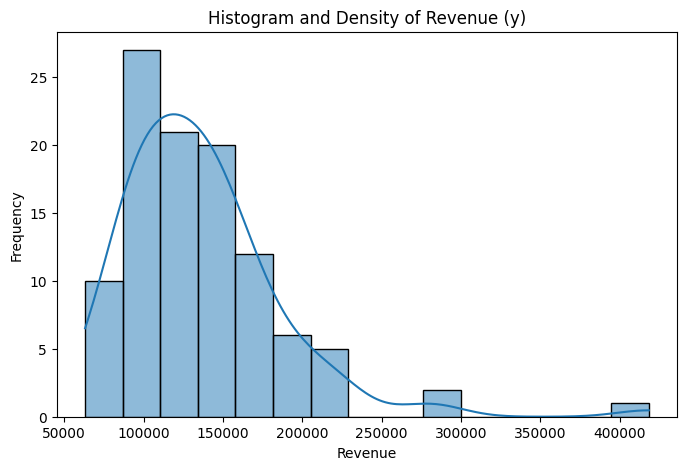

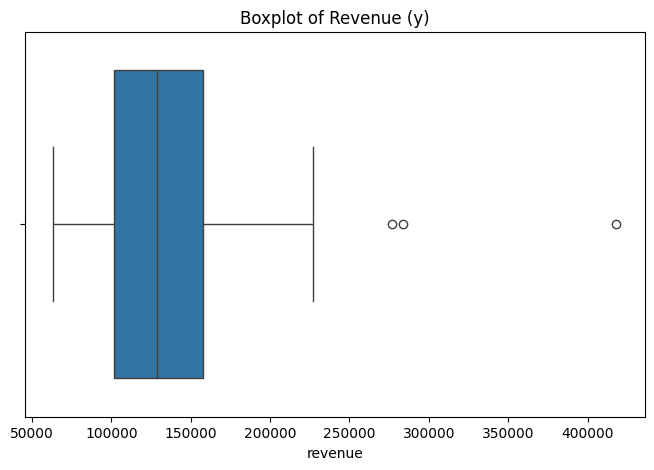

In [7]:
# examine target variable 'revenue', useful to choose likelihood
import matplotlib.pyplot as plt
import seaborn as sns

# histograms to understand distribution
plt.figure(figsize=(8, 5))
sns.histplot(df['revenue'], kde=True)
plt.title("Histogram and Density of Revenue (y)")
plt.xlabel("Revenue")
plt.ylabel("Frequency")
plt.show()

# boxplots to detect outliers
plt.figure(figsize=(8, 5))
sns.boxplot(x=df['revenue'])
plt.title("Boxplot of Revenue (y)")
plt.show()

In [ ]:
"""
From the plots, we see that revenue is continuous, positive, right‑skewed. So..."Gamma-like"
Plus, Gamma distribution tails can accomodate what little outliers appear in the plot

This is a good scenario for a Gamma Generalized Linear Model (GLM)

Bonus: shape parameter estimation. From the plots and after some tinkering, it seems that a decent initial guess for the Gamma shape/dispersion prior could be HalfNormal(5),
    which is centered at zero, has positive support and scale 5 (https://stackoverflow.com/questions/61670240/how-to-decide-on-what-priors-distributions-to-use-for-parameters-in-pymc3)
"""

'\nFrom the plots, we see that revenue is continuous, positive, right‑skewed. So..."Gamma-like"\nPlus, Gamma distribution tails can accomodate what little outliers appear in the plot\n\nThis is a good scenario for a Gamma Generalized Linear Model (GLM)\n\nBonus: shape parameter estimation. From the plots and after some tinkering, it seems that a decent initial guess for the Gamma shape/dispersion prior could be HalfNormal(5),\n    which is centered at zero, has positive support and scale 5 (https://stackoverflow.com/questions/61670240/how-to-decide-on-what-priors-distributions-to-use-for-parameters-in-pymc3)\n'

In [8]:
"""
Standardize adstock channels before fitting a model: each channel has mean 0 and unit variance. Why?
i)  Numerical stability: make input predictors roughly of "order‑one".
    This means well‑behaved linear combos η_t = β_0 + ∑_i β_i X_{t,i} that are not too large or too small.
    In turn, exp(η_t) stays in a safe numeric range and won’t overflow/underflow Gamma likelihood.
ii) Once each X_i has mean 0 and SD 1, Normal(0, 1) priors on the β_i actually correspond to "effect per one‑SD change",
    so the priors align with data scale and the coefficients become directly comparable.
"""
# standardize adstock channels
from sklearn.preprocessing import StandardScaler

adstock_cols = [f'adstock_ch_{i}' for i in range(1, 8)]
scaler = StandardScaler()

# prepare the design matrix (adstock) X and target y:
#   - X (shape 104 × 7) contains the 7 adstock-spend series, now standardized/scaled
#   - y (length 104) contains revenues
X = scaler.fit_transform(df[adstock_cols].values)
y = df['revenue'].values  # leave y unchanged

# check
print("X mean (≈0):", X.mean(axis=0))
print("X std  (≈1):", X.std(axis=0))

X mean (≈0): [ 1.11022302e-16  5.97812398e-17 -5.80732044e-16 -6.40513283e-18
 -5.76461955e-17 -5.12410627e-17  1.19562480e-16]
X std  (≈1): [1. 1. 1. 1. 1. 1. 1.]


In [24]:
# adstock-only Bayesian Gamma GLM regression
"""
GLM components (https://en.wikipedia.org/wiki/Generalized_linear_model)
- distro for modelling revenue y: Gamma distro, which is good for y_t > 0
- linear predictor η = β_0 + Xβ, where X are the (adstock) channel spends
- link function g: relates linear predictor η to the conditional response mean μ.
  Is such that E[y | X] = μ = g^{-1}(η) <=> g(μ) = ln(μ) = η.
  In our case, g^{-1}(.) = exp(.) <=> g(.) = ln(.)
- On the Gamma distro (https://en.wikipedia.org/wiki/Gamma_distribution)
-     Gamma function:   Γ(α)    =   ∫_0^∞ y^{α−1} exp(−y) dy,     for α > 0
-     Gamma PDF:        f(x;α,λ)=   λ_α/Γ(α) x^{α−1} exp(−λx),    for x > 0
-     E[X] = α/λ, Var(X) = α/λ^2

How?
- specify priors reflecting beliefs about parameter
- specify likelihood about observed variable
- run gradient‑based Monte-Carlo Markov Chain (MCMC) algorithm sampler No‑U‑Turn Sampler (NUTS)
- recover posterior distributions of the distro parameters,
- quantify updated beliefs after observing data
"""
import numpy as np

# adstock_model will be our Bayesian model
with pm.Model() as adstock_model:

  # Priors
  # β_0 (intercept): normal distro around the log of the average weekly revenue, with moderate spread (σ=2).
  #   Why the log? Look at how η and μ are computed: if X = 0, ln(μ) = η = β_0, where μ E[y | X] is the conditional mean of y. So this is a good "agnostic/apriori" guess
  #     so, basically, because Gamma distro has log-link function, then it's natural to specify β_0 in the log scale
  #   Why the sigma=2? That's a weakly informative value: rule out extremely large/small intercepts but is broad enough
  #     Also: large σ == flat prior --> can cause poor sampler behavior; small σ == tight priori can bias estimates. σ = 2 is a balanceed middle ground
  beta0 = pm.Normal('beta0', mu=np.log(y.mean()), sigma=2)
  # β_1...β_7 (channel coefficients): Normal(0, 1), weakly regularizing around zero. Should be a good choice because we standardized channels around 0.
  #   Also check https://github.com/stan-dev/stan/wiki/Prior-Choice-Recommendations
  betas = pm.Normal('betas', mu=0, sigma=1, shape=X.shape[1])
  # α (Gamma shape/dispersion parameter): controls dispersion and skewness of the distribution.
  # Since in Gamma distro α > 0, and a Normal prior would allow α < 0, we use HalfNormal: peaks at zero and decays smoothly
  # Small α == highly right‑skewed heavy‑tailed form, large α == more symmetric, nearly Normal shape
  alpha = pm.HalfNormal('alpha', sigma=5)


  # 1) compute linear preedictor η_t = β_0 + Σ_m β_m·X_m
  # 2) compute link function μ_t = exp(η_t), guarantees μ_t > 0 as the model's expected revenue
  eta = beta0 + pm.math.dot(X, betas)
  # link function is g(μ) = η, so that g^{-1}(η) = μ = E[y | X], i.e., the conditional mean of the distro
  # Log link with μ = exp(η) ensures that the model's expected revenue μ_t > 0, which goes along Gamma distro's support in (0,∞)
  mu = pm.math.exp(eta)

  # likelihood: observed data y_t assumed Gamma‑distributed with shape α and rate = α/μ_t
  # This means Gamma with  E[y_t] = μ_t and Var[y_t]=μ_t^2/α
  # beta is the rate parameter of the gamma distro (https://www.pymc.io/projects/docs/en/stable/api/distributions/generated/pymc.Gamma.html)
  y_obs = pm.Gamma('y_obs', alpha=alpha, beta=alpha/mu, observed=y)



    # MCMC sampling via NUTS in PyMC requires a concrete point in the parameter space to begin exploring

  # So, heuristically compute starting point of the model == compute value assignments for all model parameters
  init_vals = adstock_model.initial_point()
  print("initial_point:", init_vals)
  # Checks that init_vals gives a finite joint log‑prob, raises error if it's −∞ or NaN
  # In particular, evaluates joint log-proba at init_vals
  # In fact, NUTS relies on computing gradients of the log‑probability to propose new parameter values, it will get stuck if those gradients are undefined
  # Why the log-prob?
  # 1) We're trying to quantify the posterior of our data via Bayes Theorem: p(θ | D) ∝ p(θ) * p(D ∣ θ) / p(D)
  # 2) taking the logarithm: log( p(θ ∣ D) ) = log( p(θ) ) + log ( p(D ∣ θ) ), which is what NUTS works with
  adstock_model.check_start_vals(init_vals)

  # Why do we need to run NUTS? (https://medium.com/data-science/bayesian-inference-problem-mcmc-and-variational-inference-25a8aa9bce29)
  #   Prior and likelihood are relatively easy to express as they are part of the assumed model.
  #   However, the normalization factor p(D) (the "evidence") is an integral p(D) = ∫_θ p(D | θ) * p(θ) dθ that might be very hard or even infeasible to compute exactly in high dimensions.
  #   In these cases, p(D) must be approximated and MCMC algorithms are used to generate the samples needed for that approximation
  # sampling: runs NUTS for 500 tuning steps then 1000 draws, targeting a 90% acceptance rate to reduce divergences
  # output: ArviZ InferenceData object (trace) containing posterior samples
  #     --> recall that NUTS-based MCMC does not compute p(D) directly but instead it draws samples from the unnormalized posterior p(D | θ) * p(θ)
  # Parameters (https://www.pymc.io/projects/docs/en/stable/api/generated/pymc.sample.html):
  #   -   draw=1000: samples per chain
  #       chain == independent sampler run == sequence of random samples for θ, each θ dependent only on the previous one, and distribution converges to target posterior p(θ | D)
  #   -   tune=500: the first 500 iterations per chain are used to adapt the sampler's internal settings but are discarded from the final posterior sample
  #   -   step=pm.NUTS() default option
  trace = pm.sample(draws=1000, tune=500, chains=4, cores=4, initvals=init_vals, target_accept=0.9, return_inferencedata=True)

initial_point: {'beta0': array(11.82400803), 'betas': array([0., 0., 0., 0., 0., 0., 0.]), 'alpha_log__': array(1.60943791)}


Output()

            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
beta0     11.804  0.028  11.754   11.856      0.000    0.000    4619.0   
betas[0]  -0.128  0.059  -0.239   -0.020      0.001    0.001    2889.0   
betas[1]  -0.075  0.058  -0.177    0.042      0.001    0.001    2931.0   
betas[2]   0.070  0.040  -0.009    0.141      0.001    0.001    3981.0   
betas[3]   0.055  0.047  -0.036    0.139      0.001    0.001    3176.0   
betas[4]   0.099  0.069  -0.032    0.226      0.001    0.001    2942.0   
betas[5]   0.196  0.052   0.102    0.294      0.001    0.001    3556.0   
betas[6]   0.104  0.052   0.012    0.204      0.001    0.001    2902.0   
alpha     12.454  1.636   9.507   15.604      0.024    0.027    4424.0   

          ess_tail  r_hat  
beta0       2664.0    1.0  
betas[0]    2632.0    1.0  
betas[1]    2936.0    1.0  
betas[2]    2899.0    1.0  
betas[3]    3011.0    1.0  
betas[4]    2269.0    1.0  
betas[5]    2828.0    1.0  
betas[6]    2826.0    1.0  
alpha  

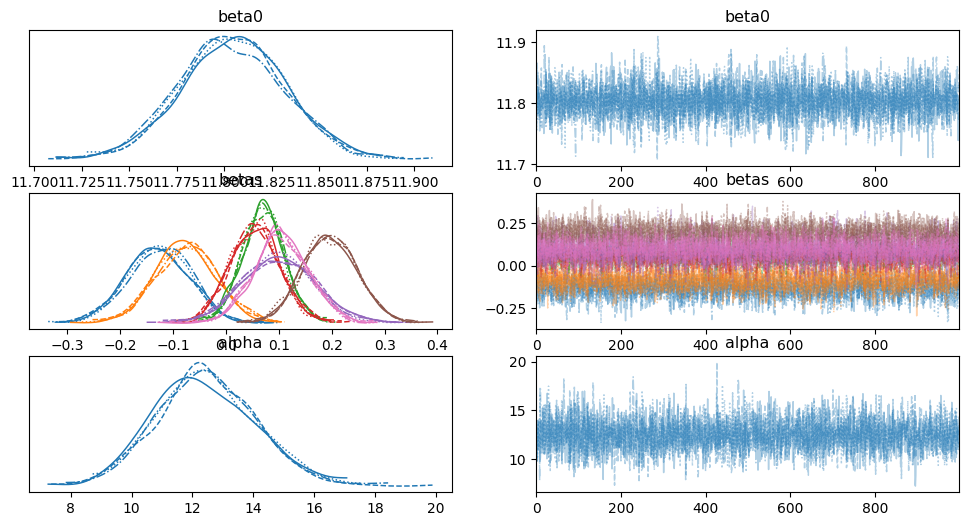

In [25]:
"""
We've just run multiple Markov chains in the MCMC sampler NUTS (with pm.sample).
Each chain is a separate sequence of draws performed to explore the same posterior distribution
"""

# MCMC-NUTS convergence diagnostics
# visually check that each chain has mixed well
az.plot_trace(trace, var_names=['beta0', 'betas', 'alpha']);
# your posterior means, standard deviations, and credible intervals on beta0, each beta, and alpha.
print(az.summary(trace, var_names=['beta0', 'betas', 'alpha']))

In [ ]:
"""
Comments on MCMC convergence diagnostics:

Table
- mean, sd: posterior mean and standard deviation for each parameter
- Highest‑Density Interval (HDI): basically this says "there is a HDI (e.g., 94%) probability that the true parameter lies in this interval (i.e., between left and right percentiles, e.g., 3rd and 97th percentiles)
    Visualization: take your MCMC samples, estimate the related posterior density via KDE, find the tightest stretch of that curve covering, say, 94% of the total area under it
    HDI is a way to report Bayesian credibility intervals (the bayesian equivalent of confidence intervals)
    Basically, if the interval is [a, b], we are saying that P( a ≤ θ ≤ b ∣ y) = γ, where γ= 94% for instance and P is the posterior
- hdi_3%, hdi_97%: left and right endpoints of the 94% HDI.
    It is the 3rd percentile of the posterior draws from 3rd to 97th percentile
  For example, there's a 94% probability that beta0 in [11.755, 11.857]. Parameters are estimated precisely
- ess_bulk: effective sample size for the bulk of the distribution --> says how many independent draws the MCMC samples are equivalent to.
  Values in the thousands: there are many "effective" samples, so Monte Carlo error is small
- ess_tail: effective sample size for the tails --> says whether the extremes of the posterior have been adequately sampled.
  Values in the hundreds or thousands are gut
- r_hat: Gelman–Rubin statistic --> compare variance within/intra chains to variance between/inter chains.
  Value 1.00 means all chains have converged to the same posterior so no evidence of poor mixing or lack of convergence


Plots:
- dotted lines are the KDEs for each individual chain, while the solid line is the average (== overall posterior approximation for param in question)
- KDE: used to produce smooth "interpolation" curve that estimates the PDF from samples produced by NUTS
"""

'\nComments on above:\n\nTable\n- mean, sd: posterior mean and standard deviation for each parameter\n- Highest‑Density Interval (HDI): basically this says "there is a HDI (e.g., 94%) probability that the true parameter lies in this interval (i.e., between left and right percentiles, e.g., 3rd and 97th percentiles)\n    Visualization: take your MCMC samples, estimate the related posterior density via KDE, find the tightest stretch of that curve covering, say, 94% of the total area under it\n    HDI is a way to report Bayesian credibility intervals (the bayesian equivalent of confidence intervals)\n    Basically, if the interval is [a, b], we are saying that P( a ≤ θ ≤ b ∣ y) = γ, where γ= 94% for instance and P is the posterior\n- hdi_3%, hdi_97%: left and right endpoints of the 94% HDI.\n    It is the 3rd percentile of the posterior draws from 3rd to 97th percentile\n  For example, there\'s a 94% probability that beta0 in [11.755, 11.857]. Parameters are estimated precisely\n- ess_bul

Output()

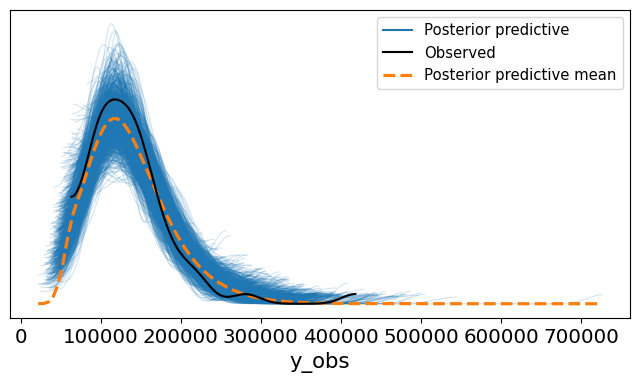

In [27]:
# posterior predictive check
# we already have some sampled parameter sets (trace) that describe plausible values for the params β_0, β, α
# now we use those sampled parameter sets to generate a new "fake" revenue according to Gamma likelihood
# basically, trace holds beliefs about the parameters after seeing real data, while ppc holds what data those beliefs would produce if they were true
# ppc is an object neatly packaged for arziv for analysis and plotting, containing many alternative versions of what data could look like under the model
with adstock_model:
  inference_data_ppc = pm.sample_posterior_predictive(trace, var_names=["y_obs"], random_seed=42, return_inferencedata=True)

# 3) Plot PPC: observed vs. simulated. overlays the distribution of replicated data against your observed y_obs so you can visually assess whether the model can reproduce key features (mean, spread, tail behavior).
az.plot_ppc(inference_data_ppc, var_names=["y_obs"],figsize=(8, 4), num_pp_samples=1000);

In [ ]:
""" https://www.pymc.io/projects/docs/en/latest/learn/core_notebooks/posterior_predictive.html
- Solid black line: KDE of actual observed y_obs data
- lighter-colored lines: KDEs of simulated/predicted y_obs from different posterior draws (inference_data_ppc). They say something about the range of possible datasets your model predicts
- orange line: KDE of avg of all simulated/predicted datasets

Comments:
- it seems that the orange line (predicted avg density) tracks the black line (assumed approximated posterior) so that's good
- the blue cloud envelopes nicely the black observed curve basically everywhere. Our model can generate data that looks like the observed
"""


" https://www.pymc.io/projects/docs/en/latest/learn/core_notebooks/posterior_predictive.html\n- Solid black line: KDE of actual observed y_obs data\n- lighter-colored lines: KDEs of simulated/predicted y_obs from different posterior draws (inference_data_ppc). They say something about the range of possible datasets your model predicts\n- orange line: KDE of avg of all simulated/predicted datasets\n\nComments:\n- it seems that the orange line (predicted avg density) tracks the black line (assumed approximated posterior) so that's good\n- the blue cloud envelopes nicely the black observed curve basically everywhere. Our model can generate data that looks like the observed\n"

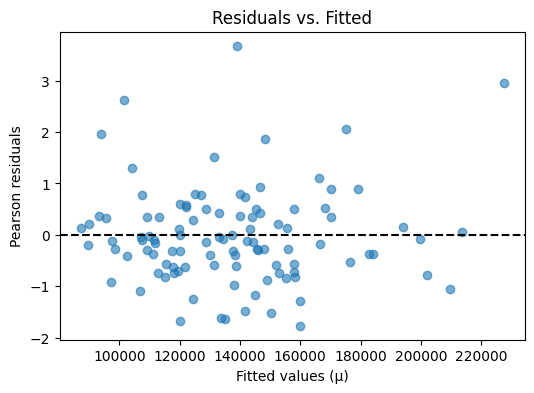

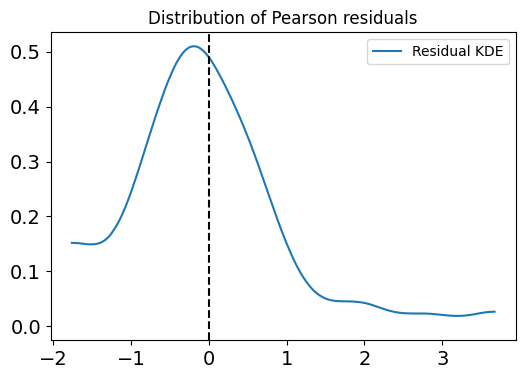

In [28]:
# compute and plot residuals and standardize them: common technique in GLMs to see how well the model fits the observed data (https://myweb.uiowa.edu/pbreheny/uk/teaching/760-s13/notes/3-26.pdf)

# compute model's posterior predictive mean (fitted μ) using inference data from previous step
mu_post = inference_data_ppc.posterior_predictive["y_obs"].mean(dim=["chain","draw"]).values

# compute model's posterior mean of the Gamma shape parameter α. This is necessary to compute model's variance: Var[y]=μ^2/α
alpha_mean = trace.posterior["alpha"].mean(dim=["chain","draw"]).values

# So now we have mean and variance, we can compute Pearson residuals (standardized differences, using std): r_i = (y_i - μ_i) / sqrt(μ_i^2/α)
"""
Raw residuals (without regularization) in a GLM will naturally grow with the mu, so plotting them against the fitted values only ends up showing increasing scale of the data and not model misfit.
Pearson residuals, instead, divide each residual by the model's own estimate of its standard deviation --> unit‑scaled residual
"""
pearson_resid = (y - mu_post) / (mu_post / np.sqrt(alpha_mean))

# scatter plots: residuals vs. fitted
plt.figure(figsize=(6,4))
plt.scatter(mu_post, pearson_resid, alpha=0.6)
plt.axhline(0, color='k', linestyle='--')
plt.xlabel("Fitted values (μ)")
plt.ylabel("Pearson residuals")
plt.title("Residuals vs. Fitted")
plt.show()

# KDE: distribution of Pearson residuals. Plot a smooth density of residuals; if the model is well‑specified, this should center at 0 and look roughly Normal
plt.figure(figsize=(6,4))
az.plot_kde(pearson_resid, label="Residual KDE")
plt.axvline(0, color='k', linestyle='--')
plt.title("Distribution of Pearson residuals")
plt.legend()
plt.show()

In [ ]:
"""
Plot 1:
- The cloud of points seems to be centered on zero. No apparent huge bias, no persistent offset wrt zero
- There are some outliers, especially in the top part of the plot but also some at the bottom
  These are few weeks where the model mis‑predicted, but there doesn't seem to be a constant misprediction
- Since we divided the model by its std, we would expect this variance to be constant.
  However, there is a very slight cone, so a potentially slight heteroscedasticity, with non-constant, growing residual variance from left to right.
  This more or less means that the Gamma’s assumption that the variance is μ^2/α underestimates variability at the high end.
  But this slight incongruence still seems tolerable and doesn't scream "WRONG MODEL!"
  Also maybe some effects can be taken into acconut by modelling seasonality

Plot 2 (residual‐KDE):
- Centered near zero: the most part of the density sits around 0, so most weeks the model's predictions are not too high or too low
- Right‐skewed tail: longer tail on the right, indicating occasional weeks where the model under‑predicts revenue more severely than it over‑predicts.
  These very few large positive residuals match the positive outliers present in Plot 1
- extremely light left tail. Negative residuals don't go beyond −2 in Plot 1 (bottom section), so over‑predictions are generally small in magnitude
- ideal residual distribution would be symmetric, but a bit of skew is not unusual in a Gamma model.
  But there are a few high-revenue weeks where the model could be improved. This begs a more thorough exploration of seasonality features
"""

'\nPlot 1:\n- The cloud of points seems to be centered on zero. No apparent huge bias, no persistent offset wrt zero\n- There are some outliers, especially in the top part of the plot but also some at the bottom\n  These are few weeks where the model mis‑predicted, but there doesn\'t seem to be a constant misprediction\n- Since we divided the model by its std, we would expect this variance to be constant.\n  However, there is a very slight cone, so a potentially slight heteroscedasticity, with non-constant, growing residual variance from left to right.\n  This more or less means that the Gamma’s assumption that the variance is μ^2/α underestimates variability at the high end.\n  But this slight incongruence still seems tolerable and doesn\'t scream "WRONG MODEL!"\n  Also maybe some effects can be taken into acconut by modelling seasonality\n\nPlot 2 (residual‐KDE):\n- Centered near zero: the most part of the density sits around 0, so most weeks the model\'s predictions are not too high

In [32]:
"""
Sources: https://mc-stan.org/loo/reference/loo-package.html, https://arxiv.org/pdf/1507.04544, https://stats.stackexchange.com/questions/471489/intuitive-explanation-of-psis-loo-cross-validation
Before adding seasonality, we establish a benchmark/baseline score quantifying how well the Gamma-based adstock-only model predicts new data.
Two common Bayesian metrics to use in this case:
- PSIS-LOO‑CV (Leave‑One‑Out Cross‑Validation using Pareto-Smoothed Importance Sampling): estimates/approximates expected (log‑)predictive density for new data.
  This is done by repeatedly leaving out one observation and measuring predictive accuracy of the model fitted on the rest.
  This trades off fit (predictions quality wrt observed data) against overfitting (model complexity).
  Higher LOO‑CV values are preferred.
"""
# if the group doesn't exist, compute it; otherwise, reuse `trace` directly
if "log_likelihood" not in trace.groups():
  inference_data = pm.compute_log_likelihood(trace, model=adstock_model, var_names=["y_obs"], extend_inferencedata=True)
else:
  inference_data = trace

# LOO
loo = az.loo(inference_data, scale="deviance")
print("\nLOO:")
print(loo)


LOO:
Computed from 4000 posterior samples and 104 observations log-likelihood matrix.

             Estimate       SE
deviance_loo  2483.85    19.15
p_loo            9.17        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)      104  100.0%
   (0.70, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%



In [33]:
"""
https://mc-stan.org/loo/reference/pareto-k-diagnostic.html
PSIS-LOO ran using 4000 posterior draws (across all chains) so the sample size S in the Pareto‑k threshold formula (see "Details" at the webpage above) is 4000
Then, that min is 0.7 so we are in the (nice) first case
"""
print(inference_data.posterior.dims)

FrozenMappingWarningOnValuesAccess({'chain': 4, 'draw': 1000, 'betas_dim_0': 7})


In [34]:
# seasonality
# first, add Fourier features: new sin-cos features quantifying waves of period 52 weeks, so that the model can learn cyclical patterns
# Note: we need two separate features to linearly model both amplitude and phase.
# Collapsing them into one term would be possible but would introduce a nonlinear parameter, so the model would no longer be a linear GLM
# sources: https://stats.stackexchange.com/questions/257785/phase-modelling-while-fitting-sine-wave-to-cyclic-data
# if one fixes the phase phi in the webpage above then we have a linear parameter again

# create a time index (0,1,2,...,103 for 104 weeks)
df["t"] = np.arange(len(df))

# define seasonal period (weeks per year)
period = 52

# transformation: one sine one cosine
df["sin1"] = np.sin(2 * np.pi * df["t"] / period)
df["cos1"] = np.cos(2 * np.pi * df["t"] / period)

# tack new features into a matrix
season_cols = ["sin1", "cos1"]
X_season = df[season_cols].values

# standardize seasonal features, so that your Normal(0,1) priors behave consistently
scaler_seas = StandardScaler()
X_season = scaler_seas.fit_transform(X_season)

# combine with existing adstock design matrix (with shape 104x7)
X_full = np.hstack([X, X_season])
print("New design matrix shape:", X_full.shape)

New design matrix shape: (104, 9)


Output()

            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
beta0     11.805  0.029  11.750   11.856      0.000    0.000    5321.0   
betas[0]  -0.140  0.058  -0.249   -0.029      0.001    0.001    2964.0   
betas[1]  -0.067  0.060  -0.182    0.045      0.001    0.001    3224.0   
betas[2]   0.077  0.039   0.006    0.153      0.001    0.001    4378.0   
betas[3]   0.048  0.046  -0.041    0.131      0.001    0.001    3497.0   
betas[4]   0.126  0.074  -0.016    0.263      0.001    0.001    2979.0   
betas[5]   0.169  0.061   0.061    0.287      0.001    0.001    2813.0   
betas[6]   0.107  0.053   0.001    0.202      0.001    0.001    3786.0   
betas[7]   0.035  0.038  -0.033    0.107      0.001    0.001    3676.0   
betas[8]   0.007  0.030  -0.051    0.061      0.000    0.000    4003.0   
alpha     12.396  1.703   9.226   15.536      0.024    0.028    4909.0   

          ess_tail  r_hat  
beta0       2680.0    1.0  
betas[0]    3032.0    1.0  
betas[1]    3135.0    1.0  

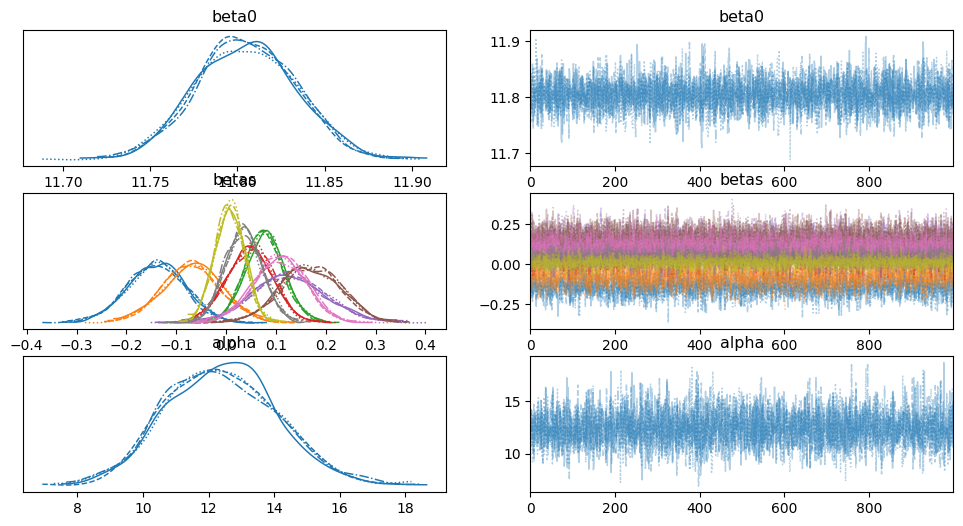

In [35]:
# fit Gamma GLM regression again, but now with new seasonal features

# new "seasonal" Bayesian Gamma GLM regression
with pm.Model() as seasonal_model:
    # Priors (same intercept prior as before and X_full now "stacks" 9 coefficients)
    beta0 = pm.Normal("beta0", mu=np.log(y.mean()), sigma=2)
    betas = pm.Normal("betas", mu=0, sigma=1, shape=X_full.shape[1])
    alpha = pm.HalfNormal("alpha", sigma=5)

    # Linear predictor + link
    eta = beta0 + pm.math.dot(X_full, betas)
    mu = pm.math.exp(eta)

    # Likelihood: Gamma(shape=alpha, rate=alpha/mu)
    y_obs = pm.Gamma("y_obs", alpha=alpha, beta=alpha/mu, observed=y)

    # Initialize and check
    init_vals = seasonal_model.initial_point()
    seasonal_model.check_start_vals(init_vals)

    # Sample with NUTS
    seasonal_trace = pm.sample(draws=1000, tune=500, chains=4, cores=4, initvals=init_vals, target_accept=0.9, return_inferencedata=True)

# Optional: Quick convergence check
az.plot_trace(seasonal_trace, var_names=["beta0", "betas", "alpha"]);
print(az.summary(seasonal_trace, var_names=["beta0", "betas", "alpha"]))


In [ ]:
"""
- All hat{R}=1.00 everywhere and ESS in the thousands, so the sampler is doing its job + there are plenty of effective draws for every parameter
- betas[7,8] (sin,cos): both their intervals comfortably include zero.
  The model has effectively shrunk the seasonal effects to close to zero.
  In other words, seasonality (at least with this transformation) doesn't seem to be a major driver of weekly revenue once adstock is accounted for.
  To prove this: the dispersion factor α is almost unchanged wrt earlier (~12.4 vs ~12.5) and the adstock coefficients shift only marginally.
  This seems to suggest that the seasonal terms are not "stealing" a lot of explanatory power from the adstock inputs

  So...it could be intereseting to try other seasonal features...maybe another day :)
"""

'\n- All hat{R}=1.00 everywhere and ESS in the thousands, so the sampler is doing its job + there are plenty of effective draws for every parameter\n- betas[7,8] (sin,cos): both their intervals comfortably include zero.\n  The model has effectively shrunk the seasonal effects to close to zero.\n  In other words, seasonality (at least with this transformation) doesn\'t seem to be a major driver of weekly revenue once adstock is accounted for.\n  To prove this: the dispersion factor α is almost unchanged wrt earlier (~12.4 vs ~12.5) and the adstock coefficients shift only marginally.\n  This seems to suggest that the seasonal terms are not "stealing" a lot of explanatory power from the adstock inputs\n\n  So...it could be intereseting to try other seasonal features...maybe another day :)\n'

In [36]:
# Compute log_likelihood for the seasonal model (adds .log_likelihood if not present)
if "log_likelihood" not in seasonal_trace.groups():
  idata_season = pm.compute_log_likelihood(seasonal_trace, model=seasonal_model, var_names=["y_obs"], extend_inferencedata=True)
else:
  idata_season = seasonal_trace

# PSIS-LOO for seasonal model
loo_season = az.loo(idata_season, scale="deviance")
print("Seasonal model LOO:")
print(loo_season)

# Compare to adstock-only
#    (assumes you still have `inference_data` for the adstock-only model)
comparison = az.compare({"adstock_only": inference_data, "with_seasonality": idata_season},
    ic="loo",
    scale="deviance"
)
print("\nModel comparison (by LOO):")
print(comparison)

Output()

/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Seasonal model LOO:
Computed from 4000 posterior samples and 104 observations log-likelihood matrix.

             Estimate       SE
deviance_loo  2486.91    18.97
p_loo           10.71        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)      102   98.1%
   (0.70, 1]   (bad)         2    1.9%
   (1, Inf)   (very bad)    0    0.0%


Model comparison (by LOO):
                  rank     elpd_loo      p_loo  elpd_diff        weight  \
adstock_only         0  2483.848713   9.165775   0.000000  1.000000e+00   
with_seasonality     1  2486.912832  10.710847   3.064119  4.440892e-16   

                         se       dse  warning     scale  
adstock_only      19.150941  0.000000    False  deviance  
with_seasonality  18.965155  1.825906     True  deviance  


/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


In [ ]:
"""
p_loo without seasonality is slightly lower/better than with, and also deviance is lower without seasonality.
All in all, it seems that seaonal feature don't add much, at least how tey are computed right now.
Considering months, festivities, etc. could add more info, though.
"""

"\np_loo without seasonality is slightly lower/better than with, and also deviance is lower without seasonality.\nAll in all, it seems that seaonal feature don't add much, at least how tey are computed right now.\nConsidering months, festivities, etc. could add more info, though.\n"

In [37]:
# compute Return On Marketing Investment (ROMI)
"""
Seasonal features (sin, cos) express cyclic time effects rather than spend-driven effects, so they do not have an associated cost.
They don't answer to the question: how much did you spend?
So they are not part of the computation of ROI, which only considers net gain and investment cost.
In MMM, ROMI (Return On Marketing Investment, https://en.wikipedia.org/wiki/Return_on_marketing_investment) is
[ "Incremental Revenue Attributable to Marketing ($)" * "Contribution Margin (%)" - "Marketing Spending ($)" ] / "Marketing Spending ($)"
i.e., incremental net revenue generated per unit of media spend.
"""

# retrieve posterior group returned by pm.sample() earlier
post = trace.posterior
# retrieve MCMC samples for intercept β_0 (array of size (chain, draw)), then returns values of reshaped array (4000,) because 4 chains each with 1000 draws
beta0_samps = post["beta0"].stack(sample=("chain","draw")).values
# similar thing, for the other β --> (4000, 7)
betas_samps = post["betas"].stack(sample=("chain","draw")).values
# get names of adstock columns ['adstock_ch_1',…,'adstock_ch_7']
channel_names = adstock_cols
# get std of adstock columns
stds = scaler.scale_

# summarize posterior of the coefficients
# summary() gives a DataFrame containing recap stats for betas
coef_df = az.summary(trace, var_names=["betas"], hdi_prob=0.94)[["mean","sd","hdi_3%","hdi_97%"]]
# set labels to channel names
coef_df.index = channel_names
print("Posterior summaries for channel log-effects:\n")
print(coef_df.round(3)) # some rounding

"""
Brief recap:
  - the model is μ=exp( β_0 + ∑_i β_i X_{i,std} ), where each X_{i,std} is one adstock channel, standardized to mean 0 and std 1
  - ROI_i is the revenue gained per extra money unit (e.g. €) spent on the i-th channel: "incremental revenue"/"incremental spend"
  - at standardized adstock channels, their mean is 0 (this is the standardized "typical spend").
    So μ_0 = exp(β_0) simply, i.e., μ_0 is the model's expected revenue "at that average/typical spend point"
  - Now ROI answers to the question: if one increases channel i-th standardized adstock by 1 std (i.e you bump X_{i,std} from 0 to 1), how does μ change?
    --> you want to compute the partial derivative: ∂exp(z)/∂z = exp(z), and here z = β_0 + ∑_i β_i X_{i,std}.
        at X_std=0, z = β_0 ==> ∂exp(z)/∂z = exp(β_0) = μ_0
  - Putting everything together: given η=β_0 + ∑_i (β_i X_{i,std}​) --> ∂μ/∂X_{i,std} = ∂μ/∂η * ∂η/∂X_{i,std} = μ_0 * β_i
  - X_{i,std} = (X_{i,raw} - X_i)/σ_i ==> X_{i,std}/X_{i,raw} = 1/σ_i, where X_raw is the unstandardize values.
    So the derivative wrt X_{i,std} is actually β_i/σ_i, meaning ∂μ/∂X_{i,std} = μ_0 * (β_i/σ_i)

"""


# ROMI: revenue change per one unit of raw adstock
# compute posterior mu with inverse log-link function
mu0 = np.exp(beta0_samps)
betas = betas_samps.T  # now shape (4000,7)
# ∂μ/∂X_{i,std} = μ_0 * (β_i/σ_i). Shape is 4000x7
roi_samps = (mu0[:, None] * betas) / stds  # stds is (7,)


# Summarize ROI for each channel ---
roi_df = pd.DataFrame(roi_samps, columns=channel_names)
# compute summary stats mean, std, highest density (credible) interval HDI for a given array of ROI samples
def summarize(x):
    # x is a pandas Series of length ~4000
    arr = x.values        # convert Series → NumPy array
    hdi_lo, hdi_hi = az.hdi(arr, hdi_prob=0.94)
    return pd.Series({
        "ROI_mean":    arr.mean(),
        "ROI_sd":      arr.std(),
        "ROI_hdi_3%":  hdi_lo,
        "ROI_hdi_97%": hdi_hi
    })
# applies summarize() to each sample column containing channel's ROI
roi_summary = roi_df.apply(summarize)
print("\nEstimated ROI (revenue per unit adstock):\n")
print(roi_summary.round(2))

best = roi_summary.loc["ROI_mean"].idxmax()  # finds the channel with highest ROI_mean
mean_roi_for_best = roi_summary.loc["ROI_mean", best]

print(f"\n Highest‑ROI channel: {best}  "
      f"(mean ROI ≈ {mean_roi_for_best:.2f} revenue units per adstock unit)")

Posterior summaries for channel log-effects:

               mean     sd  hdi_3%  hdi_97%
adstock_ch_1 -0.128  0.059  -0.239   -0.020
adstock_ch_2 -0.075  0.058  -0.177    0.042
adstock_ch_3  0.070  0.040  -0.009    0.141
adstock_ch_4  0.055  0.047  -0.036    0.139
adstock_ch_5  0.099  0.069  -0.032    0.226
adstock_ch_6  0.196  0.052   0.102    0.294
adstock_ch_7  0.104  0.052   0.012    0.204

Estimated ROI (revenue per unit adstock):

             adstock_ch_1  adstock_ch_2  adstock_ch_3  adstock_ch_4  \
ROI_mean           -21.54        -46.21          2.58          4.56   
ROI_sd               9.97         35.54          1.47          3.93   
ROI_hdi_3%         -41.53       -107.23         -0.34         -3.29   
ROI_hdi_97%         -4.42         26.30          5.20         11.33   

             adstock_ch_5  adstock_ch_6  adstock_ch_7  
ROI_mean             2.41          5.89          1.89  
ROI_sd               1.68          1.55          0.94  
ROI_hdi_3%          -0.77         

In [3]:
"""
1) How do you model spend carry-over?

TL;DR: I transformed raw spend into adstock variables via exponential decay with a 2-week half-life.

Advertising spend in a week usually does not only influence that week, but can have longer lasting "trickling" effects into the next weeks, contributing to increasing sales.
This effect is called Advertising Adstock or Carry-Over

Therefore, I applied adstock transformations to each channel's "raw" weekly spend, to get new "adstock" variables, such that each week's adstock is a mix of current week's spend plus a fraction of previous adstocks.
I used a common assumption in the literature that adstock decays exponentially, i.e., carry‑over effect shrinks by a constant proportion each week, so that recent spend has more impact than old spend.
This is modelled by applying an exponential decay filter, parametrized by a "half-life" constant, which I chose to be 2 weeks; again, this is a common assumption.
Half-life: time for adstock to fall to half its level if no new spend happens
Mathematically, the adstock at time t is:
    A_0 = spend_0
    A_t = spend_t + λ A_{t−1},    where λ = 1 - exp(-ln(2)/halflife), for t>0
"""

'\n1) How do you model spend carry-over?\n\nTL;DR: I transformed raw spend into adstock variables via exponential decay with a 2-week half-life.\n\nAdvertising spend in a week usually does not only influence that week, but can have longer lasting "trickling" effects into the next weeks, contributing to increasing sales.\nThis effect is called Advertising Adstock or Carry-Over\n\nTherefore, I applied adstock transformations to each channel\'s "raw" weekly spend, to get new "adstock" variables, such that each week\'s adstock is a mix of current week\'s spend plus a fraction of previous adstocks.\nI used a common assumption in the literature that adstock decays exponentially, i.e., carry‑over effect shrinks by a constant proportion each week, so that recent spend has more impact than old spend.\nThis is modelled by applying an exponential decay filter, parametrized by a "half-life" constant, which I chose to be 2 weeks; again, this is a common assumption.\nHalf-life: time for adstock to f

In [ ]:
"""
2) Explain your choice of prior inputs to the model?

TL;DR: I chose a Gamma GLM regression

First, I plotted the revenue, and saw is was continuous, positive, right‑skewed. So..."Gamma-like". The outliers appearing in the plot can be accommodated by the tails of a Gamma distribution.
This was a favorable setting for a Gamma Generalized Linear Model


COMPONENTS OF A GLM (GAMMA VERSION)
- chosen distribution for modelling revenue y: in our case, a Gamma distribution, which models y_t > 0
- linear predictor
    η = β_0 + Xβ,   where X is the matrix containing the (adstock) channel spends
- link function g: map relating (linking) linear predictor η to the conditional response mean μ
    g for the Gamma distribution is such that
        E[y | X] = μ = g^{-1}(η)    <=>   g(μ) = ln(μ) = η.
        so g(.) = ln(.) and its inverse is g^{-1}(.) = exp(.)
- the Gamma GLM is defined by a Gamma function, a Gamma PDF and related E and Var:
    - Gamma function:   Γ(α)    =   ∫_0^∞ y^{α−1} exp(−y) dy,     for α > 0
    - Gamma PDF:        f(x;α,λ)=   λ_α/Γ(α) x^{α−1} exp(−λx),    for x > 0
    - E[X] = α/λ, Var(X) = α/λ^2


REMARK
To decide the priors, I standardized adstock variables before fitting the model, so that each channel has mean 0 and unit variance.
The reasons are twofold:
i)  Numerical stability: input/independent predictors are now roughly of "order‑one".
    This means well‑behaved linear predictors η_t = β_0 + ∑_i β_i X_{t,i} that are not too large or too small.
    Why is this important? Becayse then exp(η_t) stays in a "safe" numeric range and will not overflow/underflow the Gamma likelihood.
ii) Once each X_i has mean 0 and std 1, Normal(0, 1) priors on β_i align with the data scale and the coefficients become directly comparable


PRIORS
- β_0: this is the intercept coefficient.
  Chosen prior: normal distribution around the log of the average weekly revenue, with moderate spread (σ=2).
  - Why the log of the mean? Since a Gamma distribution has a *log*-link function, then it is natural to specify β_0 in the log scale
    And, by the way, if X = 0 (which, on average, is the case since we standardize X), then η = β_0 and so ln(μ) = η = β_0, where μ = E[y | X] is the conditional mean of y
    So this is a good agnostic guess
  - Why the sigma=2? This is a value commonly used in weakly informative priors: it rules out extremely large/small intercepts but is still broad enough to be a good model
    Large σ means a flat prior and can apparently cause poor sampler behavior. A small σ yields a tight prior, which can bias estimates. 2 is a balanceed middle ground
- β_1...β_7: these are the adstock channel coefficients:
  Chosen prior: Normal(0, 1), which weakly regularizes around zero.
  - Why? It seems to be a reasonable enough choice because we standardized channels around 0
- α: this is the Gamma distribution shape/dispersion parameter, controlling dispersion and skewness
  Since in a Gamma distribution the constraint on α is α > 0, and a Normal prior would allow α < 0, we use HalfNormal, which is always positive, peaks at zero and decays smoothly
"""


In [ ]:
"""
3) How are your model results based on prior sampling vs. posterior sampling?

I ran posterior predictive checks (PPC), which verify that a posterior distribution of parameters can reproduce key features of the data (means, variances, skew, tails).
Large systematic gaps between observed and simulated distributions indicate a misfit of the model.

The basic idea is as follows: we sampled some parameter sets (trace) that describe plausible values for the params β_0, β, α.
PPC use them to generate new "fake" revenue data according to Gamma likelihood.
Intuitively, trace holds beliefs about the parameters after seeing real data, while PPC express the data that those beliefs would produce if they were true

In the plots, I compared observed vs. simulated data.
First good evidence: the orange line (predicted PPC avg density) tracks the black "observed" line (assumed approximated posterior)
Second good results: the blue cloud envelopes nicely the black "observed" curve basically everywhere.
This means that the model can generate data that looks a lot like the observed, which is nice
"""

In [ ]:
"""
4) How good is your model performing? How you do measure it?

Two ways to measure model performance:
a)  Residual diagnostics with Pearson residuals vs. fitted mean.
    Pearson residuals are standardized differences between observed and expected values under the fitted model.
    Why? They (can) reveal where and how the model fails to express some features of the data

    Our plots:
    Plot 1:
    - The cloud of residual points seems to be centered on zero. No apparent huge bias, no persistent offset wrt zero
    - There are some outliers, both in the top part of the plot and at the bottom, corresponding to model (bigger) prediction errors.
      However, the plot does not seem to show constant misprediction
    - Since we are plotting points regularized by the model std, we would expect variance to be constant.
      The plot shows a very slight cone, so a potentially slight heteroscedasticity, with (non-constant) growing residual variance from left to right.
      So the assumption we made upon choosing our Gamma’s model, that the variance is μ^2/α, underestimates variability a little bit.
      However, this seems to be only a slight incongruence and no "funnel" appears
    Plot 2 (residual‐KDE, distribution of teh residuals):
    - confirms results from Plot 1
    - Centered near zero: a zero Pearson residual means that the model predictions are correct, and since most of the distribution sits around zero this is a good sign.
    - Right‐skewed tail: under-predictions. There are some weeks where the model under‑predicts revenue.
      This kinda matches the outliers present in Plot 1
    - Light left tail: over-predictions. The tail is short, so these errors are not frequent, which aain is a good sign
    - Ideal residual distribution would be symmetric, but a bit of skew is not unusual in a Gamma model.
    - There are still a few high-revenue weeks where the model could be improved. I tried with seasonality but this did not seem to work as expected

b) LOO
    Computed before and after adding seasonality, to get a benchmark evaluation first of how well the Gamma-based adstock-only model predicts new data
    LOO‑CV (Leave‑One‑Out Cross‑Validation): gives an approximation of the expected (log‑)predictive density for new data.
    This is obtained by repeatedly leaving out one observation and measuring predictive accuracy on the rest

    I looked at this page https://mc-stan.org/loo/reference/pareto-k-diagnostic.html to interpret the results:
    the function was ran using 4000 posterior draws (across all chains) so the sample size S in the Pareto‑k threshold formula shown in the "Details" section on the webpage above is 4000.
    This means that k < min { (1 − 1/log10(4000), 0.7 } = 0.7.
    ==> the Pareto-Smoothed Importance Sampling (PSIS) "estimate and the corresponding Monte Carlo standard error estimate are reliable"
"""

In [ ]:
"""
5.a) What are your main insights in terms of channel performance/ effects?
5.b) Can you derive ROI (return on investment) estimates per channel? What is the best channel in terms of ROI?

Looking at "Posterior summaries for channel log-effects:"
- A positive βᵢ means that a 1‐std increase in that channel's adstock increases log revenue, and viceversa
- a 94% HDI entirely above zero contains strong evidence of a positive effect, and viceversa
- an HDI spanning zero implies uncertainty
So channels 6 and 7 seem to be the most promising in terms of their capacity to produce revenue.
There is more uncertainty in channels 3-4-5, especially 4 and 5. Channel 3 seems to have an almost only positive effect.
Channels 1 and 2, instead seem to have a negative effect according to the model, both in terms of HDI and mean.

Looking at teh ROMI results:
The results from above are confirmed here: channels 3-5 and 7 show modest positive effects, while 1 and 2 exhibit negative estimated impacts and negative ROI.
Overall, Channel 6 emerges as the clear standout winner, especially looking at its high ROMI.

A winning idea could be to cut budget on 1 and 2, and possibly allocate money to more prolific channels like 6 and 7.
"""